In [259]:
#!/usr/bin/env python
# coding=utf-8
##############################################################
 # File Name : bag_of_visual_word.py
 # Purpose : Recognition with Bag of Visual Word
 # Creation Date : 廿十八年四月四日 (週三) 廿二時廿九分十六秒
 # Last Modified : 廿十八年四月十日 (週二) 十二時38分六秒
 # Created By : SL Chung
##############################################################

import os
import cv2
import time
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import randomcolor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

train100_path = '../data/hw2_dataset/Problem3/train-100/'
train10_path  = '../data/hw2_dataset/Problem3/train-10/'
test100_path  = '../data/hw2_dataset/Problem3/test-100/'

train100 = {}
train10  = {}
test100  = {}

#Read in pictrues as dictionary type
print('Reading the imgs for bag of visual word')
for cidx, category in enumerate(os.listdir(train100_path)):
    temp_path = train100_path + category + '/'
    for fidx, file in enumerate(os.listdir(temp_path)):
        train100[cidx*100+fidx] = cv2.imread(temp_path+file)
        
for cidx, category in enumerate(os.listdir(train10_path)):
    temp_path = train10_path + category + '/'
    for fidx, file in enumerate(os.listdir(temp_path)):
        train10[cidx*10+fidx] = cv2.imread(temp_path+file)

for cidx, category in enumerate(os.listdir(test100_path)):
    temp_path = test100_path + category + '/'
    for fidx, file in enumerate(os.listdir(temp_path)):
        test100[cidx*100+fidx] = cv2.imread(temp_path+file)

def find_kp(imgs):
    mean_kp = 0
    imgs_des = {}
    for idx in imgs:
        surf = cv2.xfeatures2d.SURF_create(1000)
        kp, des = surf.detectAndCompute(imgs[idx], None)
        mean_kp = mean_kp + len(kp)
        imgs_des[idx] = des
        while(True):
            kp, des = surf.detectAndCompute(imgs[idx], None)
            if len(kp) >= 100 or (surf.getHessianThreshold() <= 300):
                mean_kp = mean_kp + len(kp)
                imgs_des[idx] = des
                '''
                if idx == 0 and imgs == train10:
                     temp = cv2.drawKeypoints(imgs[0],kp,None,(255,0,0),4)
                     cv2.imwrite("train10_0.jpg", temp)
                     print('kp for train-10_0:', len(kp))
                '''
                break  
            surf.setHessianThreshold(surf.getHessianThreshold() - 300)
    mean_kp = mean_kp / (idx+1)
    return mean_kp, imgs_des

#Choose the Train10 img and plot the interest point at most 30
print('Finding the key points for Train-10...')
mean_kp, train10_des = find_kp(train10)
print('Average Keypoint for Train-10 (50):', mean_kp, '\n')

print('Finding the key points for Train-100...')
mean_kp, train100_des = find_kp(train100)
print('Average Keypoint for Train-100 (500):', mean_kp, '\n')

print('Finding the key points for Test-100...')
mean_kp, test100_des = find_kp(test100)
print('Average Keypoint for Test-100 (500):', mean_kp, '\n')


#Start the KMeans Algorithm
c = 50
max_iteration = 5000
kmeans = KMeans(n_clusters = c, max_iter = max_iteration)

print("KMeans clustering for Train10 (c=50)...")
start_time = time.time()
alldes_train10 = np.zeros((0, 64))
for idx in train10_des:
    alldes_train10 = np.vstack((alldes_train10, train10_des[idx]))
train10_des_cluster = kmeans.fit_predict(alldes_train10)
print("--- %s seconds ---" % (time.time() - start_time))

Reading the imgs for bag of visual word
Finding the key points for Train-10...
Average Keypoint for Train-10 (50): 400.32 

Finding the key points for Train-100...
Average Keypoint for Train-100 (500): 440.92 

Finding the key points for Test-100...
Average Keypoint for Test-100 (500): 405.204 

KMeans clustering for Train10 (c=50)...
--- 7.216825723648071 seconds ---


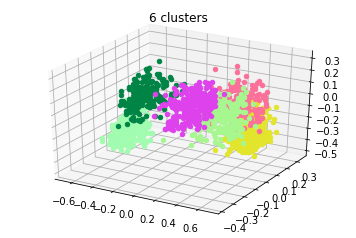

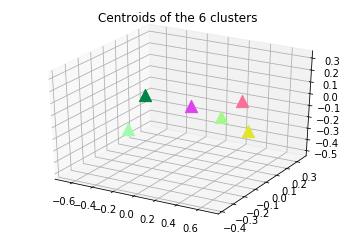

In [272]:
#Generate 6 Colors

colors = np.zeros((12,3))
rand_color = randomcolor.RandomColor()
for i in range(6):
    temp = rand_color.generate()[0]
    colors[i] = np.array([int(temp[1:3], 16), int(temp[3:5], 16), int(temp[5:7], 16)])
    
pca = PCA(n_components=3)
coor_train10 = pca.fit_transform(alldes_train10)
coor_centr = pca.transform(kmeans.cluster_centers_)
c_3D_plot = np.random.randint(c, size=6)

fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
plt.title("6 clusters")
for i in range(6):
    temp = coor_train10[np.nonzero(train10_des_cluster == c_3D_plot[i])]
    ax.scatter(temp[:,0], temp[:,1], temp[:,2], 
               c=colors[i]/255, depthshade=False)
x1,x2,y1,y2,z1,z2 = ax.get_w_lims()
plt.savefig("PCA_3D_train10.jpg")

fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(x1, x2)
ax.set_ylim3d(y1, y2)
ax.set_zlim3d(z1, z2)
plt.title("Centroids of the 6 clusters")
for i in range(6):
    temp = coor_centr[c_3D_plot[i]]
    ax.scatter(temp[0], temp[1], temp[2], c=colors[i]/255,s=150, depthshade=False, marker = '^')
plt.savefig("PCA_3D_train10_centroid.jpg")

In [262]:
def bow_table_maker(img_descriptors, c, kmeans):
    HS_bow_table = np.zeros((0, c))
    SS_bow_table = np.zeros((0, c))
    SM_bow_table = np.zeros((0, c))
    #Bag of word of each image
    for i in range(len(img_descriptors)): #50 imgs
        fc_table = np.zeros((0, c))
        for j in range(len(img_descriptors[i])): #features in an img
            dis = np.sum((kmeans.cluster_centers_ - img_descriptors[i][j]) ** 2 , 1) ** (1/2)
            fc_table = np.vstack((fc_table, dis))
        #Hard-Sum
        HS_bow = np.sum(fc_table == np.repeat(np.min(fc_table, 1).reshape(j+1, 1), c, axis=1), 0)
        HS_bow_table = np.vstack((HS_bow_table, HS_bow))

        #Soft-Sum
        SS_bow = np.sum((1/fc_table) / np.sum(1/fc_table, 1).reshape(j+1, 1), 0)
        SS_bow_table = np.vstack((SS_bow_table, SS_bow))

        #Soft-Max
        SM_bow = np.max((1/fc_table) / np.sum(1/fc_table, 1).reshape(j+1, 1), 0)
        SM_bow_table = np.vstack((SM_bow_table, SM_bow))
    return HS_bow_table, SS_bow_table, SM_bow_table
        
train10_HS_bow, train10_SS_bow, train10_SM_bow = bow_table_maker(train10_des, 50, kmeans)

In [243]:
def compare_bow(img, k, name, HS, SS, SM):
    f = plt.figure(figsize=(20,5))
    plt.subplot(1, 4, 1)
    plt.title(name)
    plt.imshow(img)
    plt.subplot(1, 4, 2)
    plt.title('Hard-Sum')
    plt.bar(np.arange(c), height=HS[k], align='center', color=colors[0]/255)
    plt.subplot(1, 4, 3)
    plt.title('Soft-Sum')
    plt.bar(np.arange(c), height=SS[k], align='center', color=colors[0]/255)
    plt.subplot(1, 4, 4)
    plt.title('Soft-Max')
    plt.bar(np.arange(c), height=SM[k], align='center', color=colors[0]/255)
    plt.savefig(name+'_bow.jpg')

338
204
358
139
264


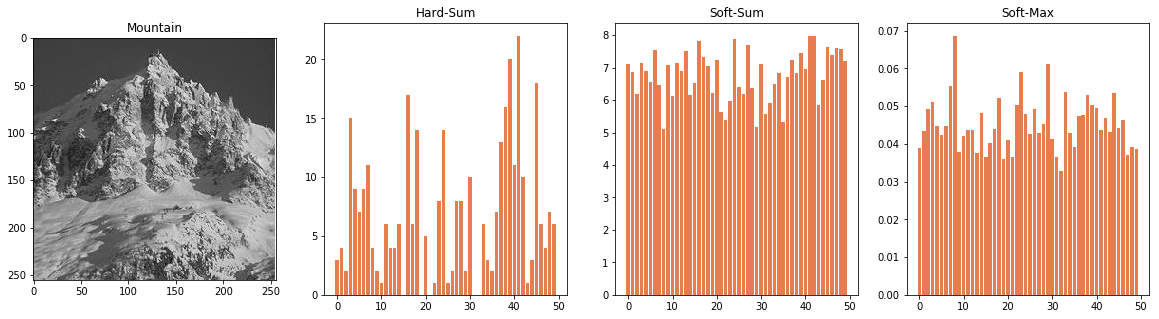

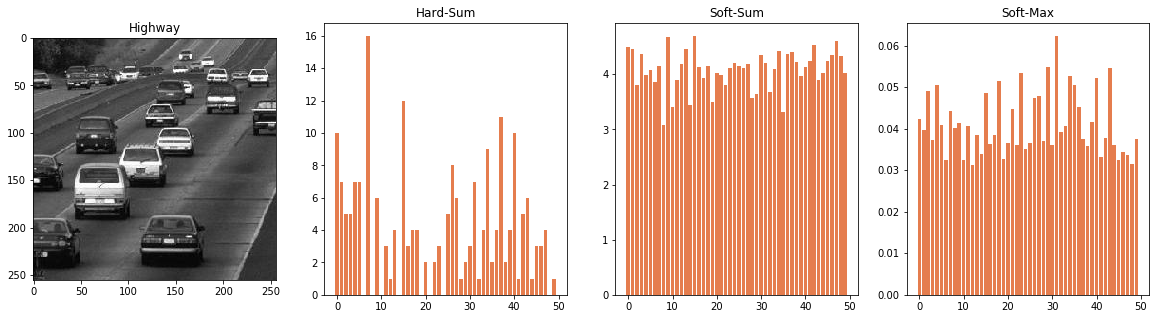

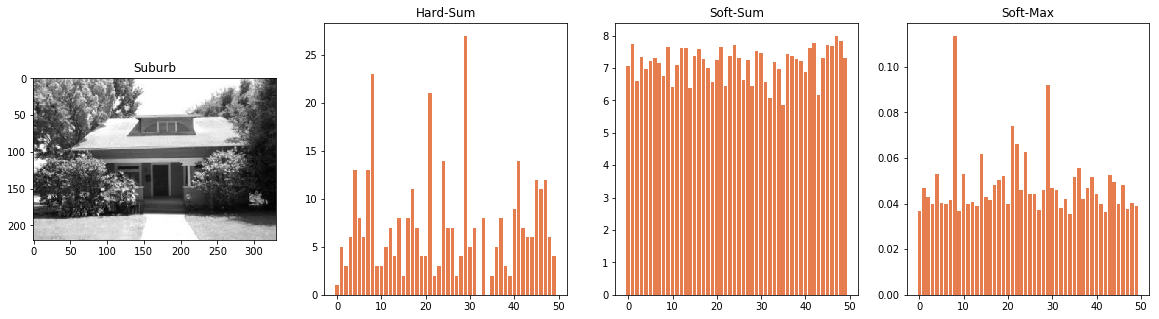

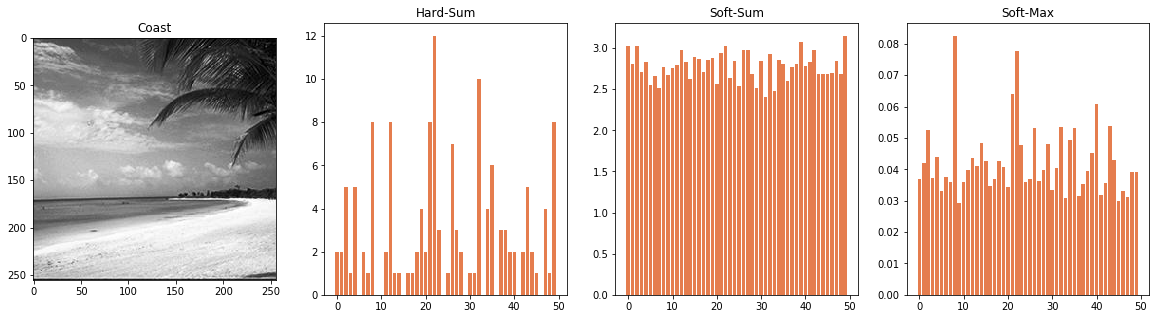

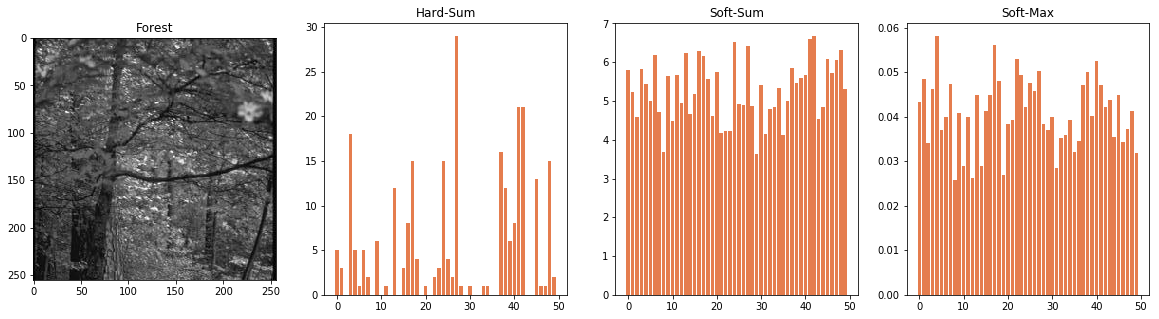

In [244]:
k = [0, 11, 20, 30, 40]
category = ['Mountain', 'Highway', 'Suburb', 'Coast', 'Forest',]
for i in range(5):
    compare_bow(train10[k[i]], k[i], category[i], train10_HS_bow, train10_SS_bow, train10_SM_bow)


In [284]:
test100_HS_bow, test100_SS_bow, test100_SM_bow = bow_table_maker(test100_des, 50, kmeans)
train100_HS_bow, train100_SS_bow, train100_SM_bow = bow_table_maker(train100_des, 50, kmeans)
print("Training data: train10   c: ", 50)
for k in range(1, 11):
    neigh = KNeighborsClassifier(n_neighbors = k)
    #Hard-Sum
    neigh.fit(train10_HS_bow, np.repeat(np.arange(5), 10))
    HS_result = neigh.predict(test100_HS_bow)
    #Soft-Sum
    neigh.fit(train10_SS_bow, np.repeat(np.arange(5), 10))
    SS_result = neigh.predict(test100_SS_bow)
    #Soft-Max
    neigh.fit(train10_SM_bow, np.repeat(np.arange(5), 10))
    SM_result = neigh.predict(test100_SM_bow)

    HS_accuracy = np.sum(np.repeat(np.arange(5), 100) == HS_result) / 500
    SS_accuracy = np.sum(np.repeat(np.arange(5), 100) == SS_result) / 500
    SM_accuracy = np.sum(np.repeat(np.arange(5), 100) == SM_result) / 500
    print("%d Accuracy of Test100 with HS/SS/SM: %5.2f / %5.2f / %5.2f" % \
          (k, HS_accuracy*100, SS_accuracy*100, SM_accuracy*100), "%")

C = [20, 50, 100, 200]
for i in range(len(C)):
    #Start the KMeans Algorithm
    max_iteration = 5000
    new_kmeans = KMeans(n_clusters = C[i], max_iter = max_iteration)

    print("KMeans clustering for Train100 (c=%d)..." % (C[i]))
    start_time = time.time()
    alldes_train100 = np.zeros((0, 64))
    for idx in train10_des:
        alldes_train100 = np.vstack((alldes_train100, train100_des[idx]))
    new_kmeans.fit_predict(alldes_train100)
    print("--- %s seconds ---" % (time.time() - start_time))

    test100_HS_bow, test100_SS_bow, test100_SM_bow = bow_table_maker(test100_des, C[i], new_kmeans)
    train100_HS_bow, train100_SS_bow, train100_SM_bow = bow_table_maker(train100_des, C[i], new_kmeans)

    print("Training data: train100   c: ", C[i])
    for k in range(1, 11, 2):
        neigh = KNeighborsClassifier(n_neighbors = k)
        #Hard-Sum
        neigh.fit(train100_HS_bow, np.repeat(np.arange(5), 100))
        HS_result = neigh.predict(test100_HS_bow)
        #Soft-Sum
        neigh.fit(train100_SS_bow, np.repeat(np.arange(5), 100))
        SS_result = neigh.predict(test100_SS_bow)
        #Soft-Max
        neigh.fit(train100_SM_bow, np.repeat(np.arange(5), 100))
        SM_result = neigh.predict(test100_SM_bow)

        HS_accuracy = np.sum(np.repeat(np.arange(5), 100) == HS_result) / 500
        SS_accuracy = np.sum(np.repeat(np.arange(5), 100) == SS_result) / 500 
        SM_accuracy = np.sum(np.repeat(np.arange(5), 100) == SM_result) / 500
        print("%d Accuracy of Test100 with HS/SS/SM: %5.2f / %5.2f / %5.2f" % \
          (k, HS_accuracy*100, SS_accuracy*100, SM_accuracy*100), "%")

Training data: train10   c:  50
1 Accuracy of Test100 with HS/SS/SM: 53.60 / 39.80 / 52.60 %
2 Accuracy of Test100 with HS/SS/SM: 42.00 / 32.00 / 47.40 %
3 Accuracy of Test100 with HS/SS/SM: 53.20 / 32.60 / 51.60 %
4 Accuracy of Test100 with HS/SS/SM: 54.40 / 31.20 / 49.60 %
5 Accuracy of Test100 with HS/SS/SM: 56.40 / 32.00 / 50.00 %
6 Accuracy of Test100 with HS/SS/SM: 55.60 / 30.60 / 47.20 %
7 Accuracy of Test100 with HS/SS/SM: 57.20 / 33.40 / 48.60 %
8 Accuracy of Test100 with HS/SS/SM: 58.00 / 32.60 / 47.00 %
9 Accuracy of Test100 with HS/SS/SM: 56.20 / 30.20 / 49.20 %
10 Accuracy of Test100 with HS/SS/SM: 54.40 / 38.40 / 46.80 %
KMeans clustering for Train100 (c=20)...
--- 4.963479042053223 seconds ---
Training data: train100   c:  20
1 Accuracy of Test100 with HS/SS/SM: 64.60 / 57.20 / 49.80 %
3 Accuracy of Test100 with HS/SS/SM: 66.60 / 60.00 / 52.40 %
5 Accuracy of Test100 with HS/SS/SM: 67.80 / 58.20 / 54.60 %
7 Accuracy of Test100 with HS/SS/SM: 70.80 / 58.20 / 57.60 %
9 Acc